In [179]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
from statistics import mean
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [212]:
# read dataset
echo_genres = pd.read_csv('//Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


## Binary Classification Rock - Hip-Pop

In [213]:
# select subset of data with genres: Hip Hop or Rock
rock_hpop = echo_genres[echo_genres['genre_top'].isin(['Hip-Hop','Rock'])]
rock_hpop.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [182]:
# check shape
rock_hpop.shape

(4802, 9)

In [183]:
rock_hpop.genre_top.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [214]:
# encoding labels
le = preprocessing.LabelEncoder()
rock_hpop['genre_top'] = le.fit_transform(rock_hpop['genre_top'])
print('legend:\n0: Hip-Hop\n1: Rock')
rock_hpop.genre_top.value_counts()


legend:
0: Hip-Hop
1: Rock


1    3892
0     910
Name: genre_top, dtype: int64

In [224]:
# Define the labels
labels = rock_hpop[['genre_top']]
# labels has as index the id_track, this creates problems when plotting data after the features have been normalized.
# we reset the index from 0 to n
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

1    3892
0     910
Name: genre_top, dtype: int64

In [225]:
rock_hpop.drop('genre_top', axis=1, inplace=True)

In [226]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rock_hpop)

# 1. PCA on scaled data
### 1.1 scree-plot
We use PCA to determine by how much we can reduce the dimensionality of our data.
We can use scree-plots and cumulative explained ratio plots to find the number of components to
use in further analysis.
- Screen-plots display the number of components against the variance explained by each component,sorted
in descending order of variance.
The cutoff is determined by the 'elbow' of the screen plot.

Text(0.5, 0, 'Principal Component #')

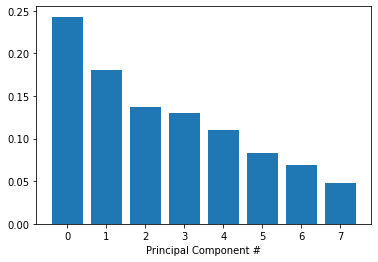

In [227]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

From the plot we can see that is not straightforward to identify the optimal number of components.
We will determine the optimal number of components by inspecting the cumulative explained
variance plot.

### 1.2 cumulative explained variance plot

Optimal number of components: 6
Explained variation per principal component:
[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


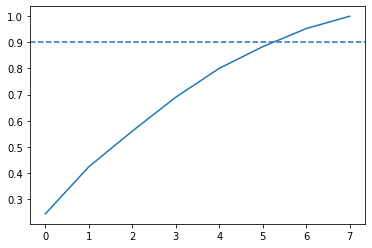

In [228]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

### 1.3 plot PCA in 2D

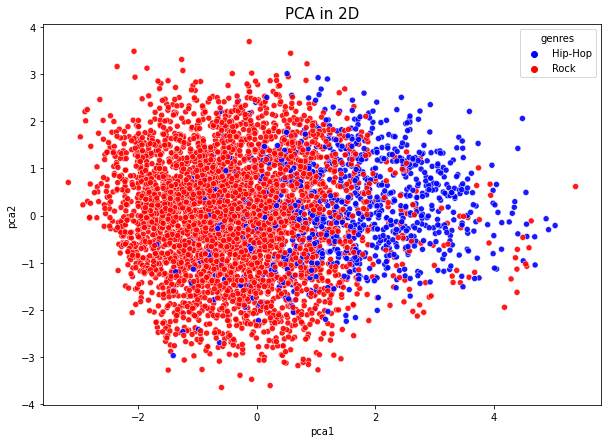

In [264]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = labels.apply(lambda x: "Rock" if x==1 else "Hip-Hop")

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    palette={'Hip-Hop':'blue','Rock':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

# 1.4 plot PCA in 3D

In [257]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()


# 2. t-SNE on scaled data [TODO]

# Model selection

In [ ]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

In [ ]:
# check partition
print(f"____Legend____\n1: Rock\n0: Hip-Hop\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

# Decision Tree - binary class - Unbalanced

### 10 fold cross validation - grid search

In [42]:
param_grid = {
               "max_depth": [2,3,4,5,6,7,8,9,10, None],
               "min_samples_leaf": [25,35,45,55,75,100,150,250,300,None],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.897 (std: 0.016)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.896 (std: 0.014)
Parameters: {'criterion': 'entropy', 'ma

### 5 fold cross validation - grid search

In [43]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 55}

Model with rank: 1
Mean validation score: 0.899 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samp

## Retrain on full development set and prediction

Accuracy 0.9111727966689799
F1-score [0.75097276 0.94594595]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       272
           1       0.93      0.96      0.95      1169

    accuracy                           0.91      1441
   macro avg       0.87      0.83      0.85      1441
weighted avg       0.91      0.91      0.91      1441



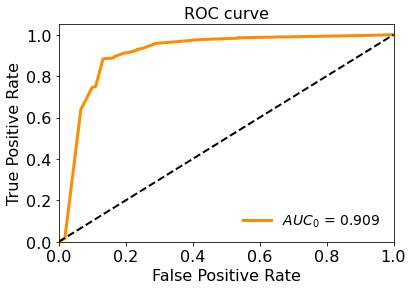

In [44]:
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 10)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

y_score = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Hip-Hop
1: Rock
[[ 465  173]
 [  90 2633]]


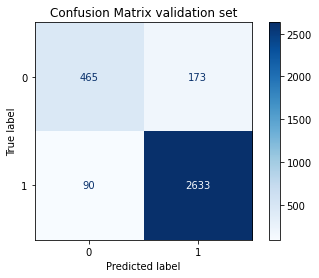

In [45]:
# confusion matrix
print("Legend:\n0: Hip-Hop\n1: Rock")
cm = plot_confusion_matrix(dtc,X_develop,y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()

# KNN binary class - Unbalanced

### Grid search

In [46]:
# range of k to try - find a good range of k
k_range = range(1, 400)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_develop, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 399/399 [03:17<00:00,  2.02it/s]


[0.8842623993217466, 0.8744427370354669, 0.9047936978945881, 0.9021115938957184, 0.9068726155150488, 0.9098488059912393, 0.9071702345626678, 0.9116336371343788, 0.908658329800763, 0.9104449272290518, 0.9077654726579059, 0.9098488059912391, 0.9065758796100043, 0.9083615938957184, 0.9047910484668644, 0.9083624770382931, 0.9050886675144835, 0.9083598276105695, 0.9044934294192453, 0.9056830224671468, 0.9030053341811503, 0.9050886675144835, 0.9030071004662993, 0.9044934294192455, 0.9033029532287692, 0.9044925462766708, 0.9018130917055249, 0.9030044510385757, 0.9009220008478168, 0.901219619895436, 0.8982425462766708, 0.9009220008478168, 0.8994330224671472, 0.8985401653242902, 0.8970529532287692, 0.9000273774198106, 0.8985375158965663, 0.8985392821817154, 0.897049420658471, 0.8985383990391409, 0.8970503038010456, 0.8973496891338136, 0.896753567896001, 0.8970520700861947, 0.8961618623710612, 0.8961609792284866, 0.895864243323442, 0.89675533418115, 0.8958615938957184, 0.8949696198954358, 0.8937

Text(0, 0.5, 'Cross-validated accuracy')

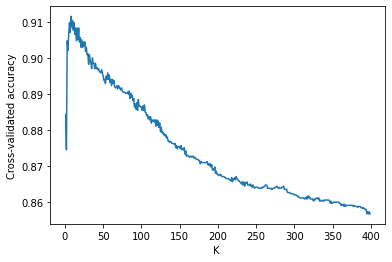

In [47]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

### Repeat 10 fold cv for 10 times and average results

In [48]:
# repeat cv 10 times and average the results - to reduce the variance of the estimate
rep_kval_scor= {'mean': 0, 'std':0}
for i in range(10):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k_scores.index(max(k_scores))+1)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    score = cross_val_score(knn, X_develop, y_develop, cv=10, scoring='accuracy', verbose=1)
    # append mean of scores for k neighbors to k_scores list
    rep_kval_scor['mean'] += score.mean()
    rep_kval_scor['std']+= score.std()

print(f"accuracy over 10 cv repeated 10 times:\n\
mean: {rep_kval_scor['mean']/10} std(+/-): {rep_kval_scor['std']/10}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

accuracy over 10 cv repeated 10 times:
mean: 0.911633637134379 std(+/-): 0.015118746474933617


## Prediction on Internal test set (KNN)

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       272
           1       0.94      0.96      0.95      1169

    accuracy                           0.92      1441
   macro avg       0.88      0.85      0.86      1441
weighted avg       0.92      0.92      0.92      1441

legend:
0: Hip-Hop
1: Rock


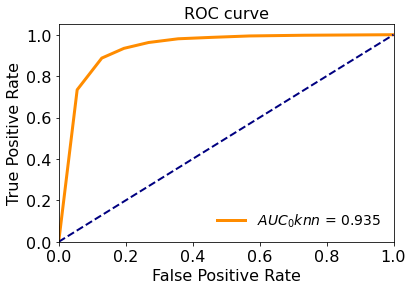

In [49]:
knn_classifier =  KNeighborsClassifier(n_neighbors = 8)

# retrain knn on the whole development set
knn_classifier.fit(X_develop, y_develop)
# predict target variable
y_pred_knn = knn_classifier.predict(X_test)
# display classification report
print(classification_report(y_test, y_pred_knn))
print('legend:\n0: Hip-Hop\n1: Rock')

# plot ROC curve -KNN
y_scoreknn = knn_classifier.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scoreknn[:, 1])
roc_auc1 = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_0knn$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Hip-Hop
1: Rock
[[ 487  151]
 [  97 2626]]


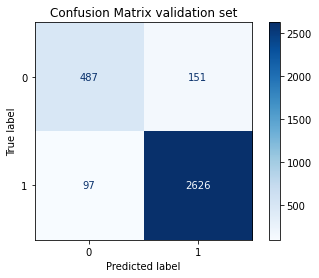

In [50]:
print("Legend:\n0: Hip-Hop\n1: Rock")
cm = plot_confusion_matrix(knn_classifier,X_develop,y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()

# KNN with PCA

## Grid Search (PCA)

In [51]:
k_range = range(1, 300)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_pca, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 299/299 [01:29<00:00,  3.34it/s]


[0.8283303306485801, 0.7997686166454713, 0.8482637416984599, 0.8405335947435354, 0.8565988413169421, 0.8577902006499929, 0.8628444256040695, 0.864929525222552, 0.8693911615091141, 0.86582061608026, 0.868500070651406, 0.8670119754133108, 0.8670110922707362, 0.8673095944609297, 0.8664176204606472, 0.8682015684612123, 0.8679039494135934, 0.869093542461495, 0.8682006853186378, 0.8705816376995902, 0.8708810230323584, 0.8714753779850218, 0.8702849017945458, 0.8705816376995902, 0.8679039494135934, 0.8696896636993076, 0.866415854175498, 0.8679048325561679, 0.8684991875088315, 0.8684991875088313, 0.869986399604352, 0.8696896636993076, 0.8696896636993076, 0.8708792567472093, 0.8720679666525364, 0.8738536809382506, 0.8720679666525364, 0.8708783736046348, 0.8711742263671047, 0.869687014271584, 0.8711751095096792, 0.8687941571287269, 0.869091776176346, 0.8693911615091141, 0.8702831355093966, 0.8708801398897839, 0.8699881658895012, 0.8696896636993078, 0.8714744948424474, 0.8699872827469266, 0.869391

## Predict on Internal test set (KNN - PCA)

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       272
           1       0.92      0.95      0.93      1169

    accuracy                           0.89      1441
   macro avg       0.83      0.80      0.81      1441
weighted avg       0.89      0.89      0.89      1441

legend:
0: Hip-Hop
1: Rock


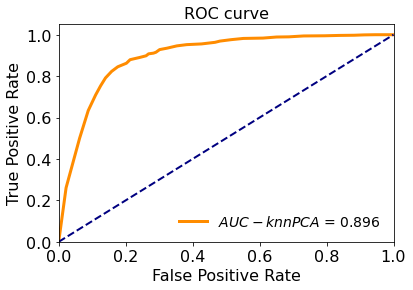

In [52]:
knn_pca  = KNeighborsClassifier(n_neighbors = 36)

# retrain knn on the whole development set
knn_pca.fit(X_pca, y_develop)
# predict target variable
y_pred_knnpca = knn_pca.predict(X_testPCA)
# display classification report
print(classification_report(y_test, y_pred_knnpca))
print('legend:\n0: Hip-Hop\n1: Rock')

# plot ROC curve -KNN
y_scoreknnpca = knn_pca.predict_proba(X_testPCA)
fpr_knnpca, tpr_knnpca, _ = roc_curve(y_test, y_scoreknnpca[:, 1])
roc_auc2 = auc(fpr_knnpca, tpr_knnpca)

plt.plot(fpr_knnpca, tpr_knnpca, color='darkorange', lw=3, label='$AUC-knnPCA$ = %.3f' % roc_auc2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Hip-Hop
1: Rock
[[ 378  260]
 [ 154 2569]]


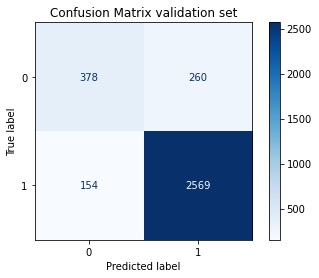

In [53]:
print("Legend:\n0: Hip-Hop\n1: Rock")
cm = plot_confusion_matrix(knn_pca,X_pca,y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()

## Compare ROC curve of KNN (with and without PCA) - unbalanced

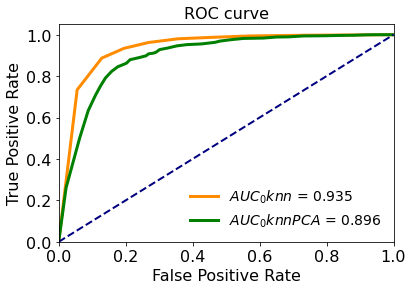

In [54]:
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_0knn$ = %.3f' % roc_auc1)
plt.plot(fpr_knnpca, tpr_knnpca, color='green', lw=3, label='$AUC_0knnPCA$ = %.3f' % roc_auc2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()